In [1]:
import random
import numpy as np
import pandas as pd
import hierarchical_umap as h_umap


import matplotlib.pyplot as plt
import demap
import math

from sklearn.neighbors import NearestNeighbors

from sklearn.utils import check_array

from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA

In [2]:
import demap
import random
import math
from sklearn.metrics import euclidean_distances

from sklearn.neighbors import NearestNeighbors

from scipy.stats import pearsonr

def correlation(X, X_emb):
    
    high = []
    emb = []
    
    for i in range(X.shape[0]):
        for j in range(i+1, X.shape[0]):
            high.append(np.linalg.norm(X[i]-X[j]))
            emb.append(np.linalg.norm(X_emb[i]-X_emb[j]))
    
    high = np.array(high)
    emb = np.array(emb)
    
    return pearsonr(high, emb)[0]
        
    
    #     for i in range(X.shape[0]):
#         for j in range(X.shape[0]):
#             num += (np.linalg.norm(X[i]-X[j]) - np.linalg.norm(X_emb[i]-X_emb[j]))**2

def stress(X, X_emb):
    
#     num = 0.0
#     den = 0.0
    
#     for i in range(X.shape[0]):
#         for j in range(X.shape[0]):
#             num += (np.linalg.norm(X[i]-X[j]) - np.linalg.norm(X_emb[i]-X_emb[j]))**2
            
#             den += np.linalg.norm(X_emb[i]-X_emb[j])**2
            
#     return math.sqrt(num/den)
    
    
    
    DE = euclidean_distances(X_emb)
    DE = DE/np.max(DE)
    DH = euclidean_distances(X)
    DH = DH/np.max(DH)
    stress = 0.5 * np.sum((DE - DH)**2)
    
    return np.sqrt(stress/(0.5*np.sum(DH**2)))
    

def neighborhood_preservation(X, X_emb, Khigh=30):
    
    neigh_high = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_high.fit(X)
    high_dists, high_indices = neigh_high.kneighbors(X)


    neigh_emb = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_emb.fit(X_emb)
    emb_dists, emb_indices = neigh_emb.kneighbors(X_emb)

    npres = np.zeros(Khigh)
    
    for k in range(1, Khigh+1):
        for i in range(X.shape[0]):
            high_current = high_indices[i][1:k+1]
            emb_current = emb_indices[i][1:k+1]
            
            tp = len(np.intersect1d(high_current, emb_current))
            
            npres[k-1] += (tp/k)
        
        
    npres /= float(X.shape[0])
    
    return npres


In [3]:
# fashionTrain = pd.read_csv('data/fashion-train.csv')

# fashionX = fashionTrain.values[:,2:]
# fashionY = fashionTrain.values[:, 1].astype(int)

# # print(fashionX.shape, fashionY.shape)

# X = fashionX
# X = normalize(X)
# y = fashionY


X = np.load('./data/MNIST_70000.npy')
y = np.load('./data/MNIST_70000_label.npy').astype(int)
X = normalize(X)
# data = pd.read_csv('data/mnist_max_pooling2d_dense.data', header=None)
# data = data.drop(columns=[0])
# X = data.values[:, :-1]
# y = data.values[:, -1]

# X = np.loadtxt("data/mammals-20000_features.txt")
# y = np.loadtxt("data/mammals-20000_classes.txt")
# X = normalize(X)

# data = pd.read_csv('data/gene_expression.csv')
# X = data.values[:, :-1]
# y = data.values[:, -1]
# X = np.log(X+1)
# X = PCA(n_components=100).fit_transform(X)
# X = normalize(X)





X = check_array(X, dtype=np.float32, accept_sparse='csr', order='C')
dataset='mnist'

In [4]:
hUmap = h_umap.HUMAP('precomputed', np.array([0.206971429, 0.184497515, 0.155630378]), 90, 0.15, "NNDescent", True)
hUmap.fit(X, y)

In [5]:
X_3 = X[hUmap.get_original_indices(3), :]
X_2 = X[hUmap.get_original_indices(2), :]
X_1 = X[hUmap.get_original_indices(1), :]

embedding_3 = hUmap.get_embedding(3)
y_3 = hUmap.get_labels(3)

embedding_2 = hUmap.get_embedding(2)
y_2 = hUmap.get_labels(2)

embedding_1 = hUmap.get_embedding(1)
y_1 = hUmap.get_labels(1)

embedding_0 = hUmap.get_embedding(0)
y_0 = y


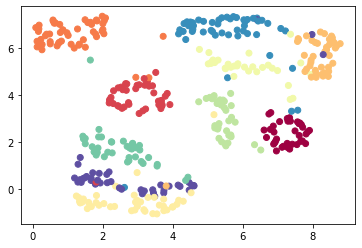

In [6]:
plt.scatter(embedding_3[:, 0], embedding_3[:, 1], c=y_3, alpha=1, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-level3.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (416, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.2771
Computing Stress...
stress:  0.5092633100734795
Computing correlation...
correlation:  0.2527308148582874
Computing Neighborhood Preservation...


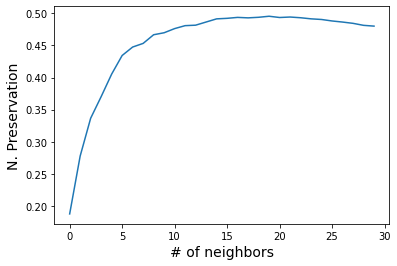

In [7]:
indices_3 = random.sample(range(0, len(y_3)), min(3000, len(y_3)))

subset_emb_3 = embedding_3[indices_3]
subset_X_3 = X_3[indices_3]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_3, subset_emb_3)))
print("Computing Stress...")
print("stress: ", stress(subset_X_3, subset_emb_3))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_3, subset_emb_3))


print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_3, subset_emb_3)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-level3-np.png')
plt.show()

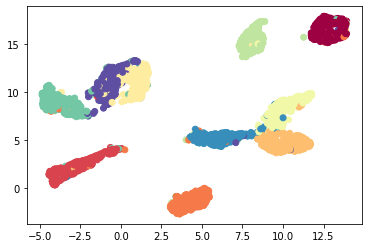

In [8]:
plt.scatter(embedding_2[:, 0], embedding_2[:, 1], c=y_2, alpha=1, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-level2.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (2673, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.4919
Computing Stress...
stress:  0.538979395042163
Computing correlation...
correlation:  0.3991241348787882
Computing Neighborhood Preservation...


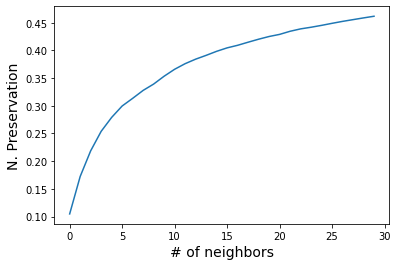

In [9]:
indices_2 = random.sample(range(0, len(y_2)), min(3000, len(y_2)))

subset_emb_2 = embedding_2[indices_2]
subset_X_2 = X_2[indices_2]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_2, subset_emb_2)))
print("Computing Stress...")
print("stress: ", stress(subset_X_2, subset_emb_2))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_2, subset_emb_2))


print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_2, subset_emb_2)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-level2-np.png')
plt.show()

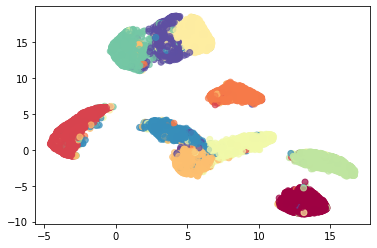

In [10]:
plt.scatter(embedding_1[:, 0], embedding_1[:, 1], c=y_1, alpha=0.7, cmap='Spectral')
plt.savefig('figs/'+dataset+'-umap-level1.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (3000, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.5183
Computing Stress...
stress:  0.5518898316728423
Computing correlation...
correlation:  0.39715277679486544
Computing Neighborhood Preservation...


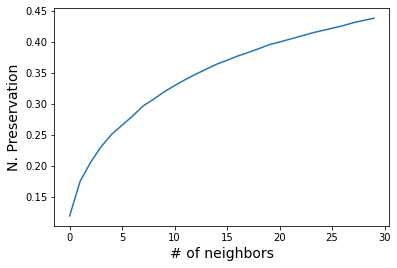

In [11]:
indices_1 = random.sample(range(0, len(y_1)), min(3000, len(y_1)))

subset_emb_1 = embedding_1[indices_1]
subset_X_1 = X_1[indices_1]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_1, subset_emb_1)))
print("Computing Stress...")
print("stress: ", stress(subset_X_1, subset_emb_1))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_1, subset_emb_1))

print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_1, subset_emb_1)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-level1-np.png')
plt.show()

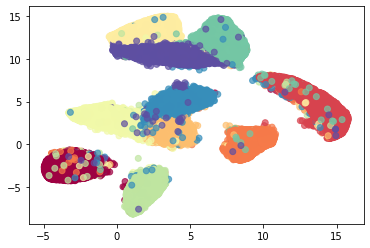

In [12]:
plt.scatter(embedding_0[:, 0], embedding_0[:, 1], c=y_0, alpha=0.7, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-level0.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (3000, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.5666
Computing Stress...
stress:  0.53156394625874
Computing correlation...
correlation:  0.4454716584694409
Computing Neighborhood Preservation...


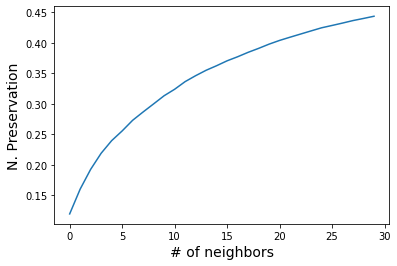

In [13]:
indices_0 = random.sample(range(0, len(y_0)), min(3000, len(y_0)))

subset_emb_0 = embedding_0[indices_0]
subset_X_0 = X[indices_0]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_0, subset_emb_0)))
print("Computing Stress...")
print("stress: ", stress(subset_X_0, subset_emb_0))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_0, subset_emb_0))



print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_0, subset_emb_0)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-level0-np.png')
plt.show()

In [14]:
embedding_cluster1 = hUmap.project(3, np.array([1]))
y_cluster1 = hUmap.get_labels_selected()
indices_cluster1 = hUmap.get_indices_selected()
X_cluster1 = X_2[indices_cluster1]

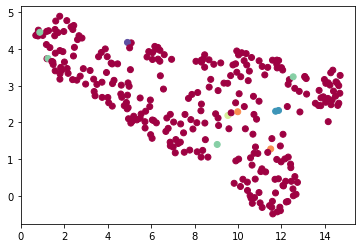

In [15]:
plt.scatter(embedding_cluster1[:, 0], embedding_cluster1[:, 1], c=y_cluster1, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-expand2.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (293, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.9371
Computing Stress...
stress:  0.47557424739384535
Computing correlation...
correlation:  0.8817381531654525
Computing Neighborhood Preservation...


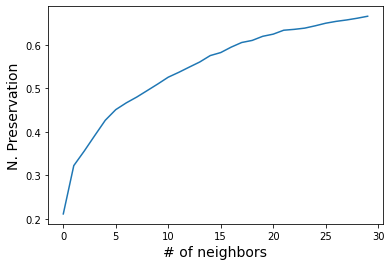

In [16]:
indices_cluster1 = random.sample(range(0, len(y_cluster1)), min(5000, len(y_cluster1)))

subset_emb_cluster1 = embedding_cluster1[indices_cluster1]
subset_X_cluster1 = X_cluster1[indices_cluster1]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_cluster1, subset_emb_cluster1)))
print("Computing Stress...")
print("stress: ", stress(subset_X_cluster1, subset_emb_cluster1))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_cluster1, subset_emb_cluster1))



print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_cluster1, subset_emb_cluster1)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-expand2-np.png')
plt.show()

In [17]:
embedding_cluster = hUmap.project(2, np.array([1]))
y_cluster = hUmap.get_labels_selected()
indices_cluster = hUmap.get_indices_selected()
X_cluster = X_1[indices_cluster]

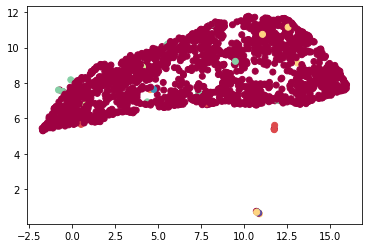

In [18]:
plt.scatter(embedding_cluster[:, 0], embedding_cluster[:, 1], c=y_cluster, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-expand1.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (1685, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.9433
Computing Stress...
stress:  0.47522410750202737
Computing correlation...
correlation:  0.8893291536639683
Computing Neighborhood Preservation...


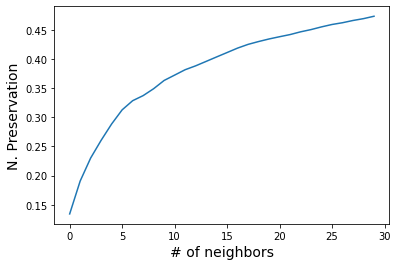

In [19]:
indices_cluster = random.sample(range(0, len(y_cluster)), min(5000, len(y_cluster)))

subset_emb_cluster = embedding_cluster[indices_cluster]
subset_X_cluster = X_cluster[indices_cluster]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_cluster, subset_emb_cluster)))
print("Computing Stress...")
print("stress: ", stress(subset_X_cluster, subset_emb_cluster))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_cluster, subset_emb_cluster))



print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_cluster, subset_emb_cluster)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-expand1-np.png')
plt.show()

In [20]:
embedding_cluster0 = hUmap.project(1, np.array([1]))
y_cluster0 = hUmap.get_labels_selected()
indices_cluster0 = hUmap.get_indices_selected()
X_cluster0 = X[indices_cluster0]

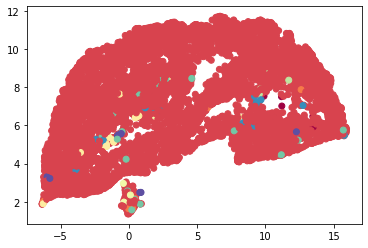

In [21]:
plt.scatter(embedding_cluster0[:, 0], embedding_cluster0[:, 1], c=y_cluster0, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-expand2.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (5000, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.9171
Computing Stress...
stress:  0.46075010630794583
Computing correlation...
correlation:  0.8594401437646597
Computing Neighborhood Preservation...


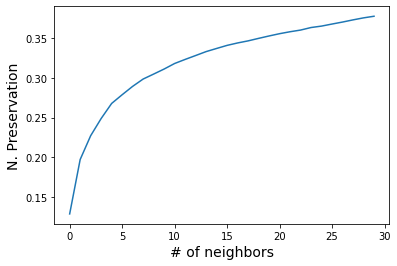

In [22]:
indices_cluster0 = random.sample(range(0, len(y_cluster0)), min(5000, len(y_cluster0)))

subset_emb_cluster0 = embedding_cluster0[indices_cluster0]
subset_X_cluster0 = X_cluster0[indices_cluster0]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_cluster0, subset_emb_cluster0)))
print("Computing Stress...")
print("stress: ", stress(subset_X_cluster0, subset_emb_cluster0))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_cluster0, subset_emb_cluster0))


print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_cluster0, subset_emb_cluster0)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-expand2-np.png')
plt.show()